This notebook reproduces (to rough visual accuracy), Figure 11 of [Frougier 2015]( https://doi.org/10.1109/VLSIT.2016.7573445)

In [1]:
%matplotlib inline
from ipywidgets import interact, FloatSlider, HTML
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',size=18)
import numpy as np
import warnings


from hyperfet.devices import SCMOSFET,VO2,HyperFET
import hyperfet.approximations as appr
from hyperfet.references import si

In [5]:
vo2_params={
    "rho_m":si("1e-4 ohm cm"),
    "rho_i":si("1e1 ohm cm"),
    "J_MIT":si("10**-2.9 A/(70um)**2"),
    "J_IMT":si("10**-3.9 A/(70um)**2"),
    "v_met":0,
    "L":si("70um"),
    "W":si("70um"),
    "T":si("235nm")
}
vo2=VO2(**vo2_params)

VDD=.3

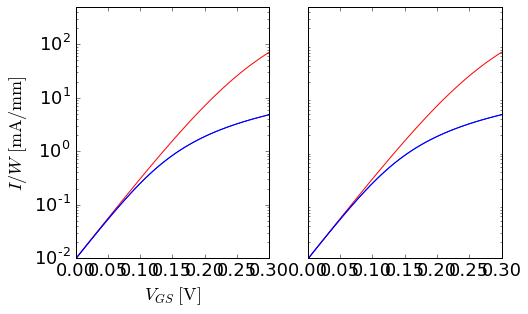

In [12]:
fet=None
out=HTML()
@interact(VT0=FloatSlider(value=.35,min=0,max=1,step=.05,continuous_update=False),
          W=FloatSlider(value=50,min=10,max=100,step=10,continuous_update=False),
          Cinv_vxo=FloatSlider(value=3000,min=1000,max=5000,step=400,continuous_update=False),
          SS=FloatSlider(value=.065,min=.05,max=.09,step=.005,continuous_update=False),
          alpha=FloatSlider(value=2.5,min=0,max=5,step=.5,continuous_update=False),
          beta=FloatSlider(value=1.8,min=0,max=4,step=.1,continuous_update=False),
          VDD=FloatSlider(value=.3,min=.3,max=1,step=.05,continuous_update=False),
          VDsats=FloatSlider(value=.1,min=.1,max=2,step=.1,continuous_update=False),
          delta=FloatSlider(value=.1,min=0,max=.5,step=.1,continuous_update=False),
          log10Gleak=FloatSlider(value=-12,min=-14,max=-5,step=1,continuous_update=False)
         )
def show_hf(VT0,W,Cinv_vxo,SS,alpha,beta,VDsats,VDD,delta,log10Gleak):
    global fet
    plt.figure(figsize=(11.8,4.5))
    fet=SCMOSFET(
        W=W*1e-9,Cinv_vxo=Cinv_vxo,
        VT0=VT0,alpha=alpha,SS=SS,delta=delta,
        VDsats=VDsats,beta=beta,Gleak=10**log10Gleak)
    
    shift=appr.shift(HyperFET(fet,vo2),VDD)
    fet2=SCMOSFET(
        W=W*1e-9,Cinv_vxo=Cinv_vxo,
        VT0=VT0+shift,alpha=alpha,SS=SS,delta=delta,
        VDsats=VDsats,beta=beta,Gleak=10**log10Gleak)
    hf2=HyperFET(fet2,vo2)
    
    VD=np.array(VDD)
    VG=np.linspace(0,VDD,100)

    plt.subplot(131)
    I=np.ravel(fet.ID(VD=VD,VG=VG))
    plt.plot(VG,I/fet.W,'r')
    
    hf=HyperFET(fet,vo2)
    If,Ib=[np.ravel(i) for i in hf.I_double(VD=VD,VG=VG)]
    plt.plot(VG[~np.isnan(If)],If[~np.isnan(If)]/fet.W,'b')
    plt.plot(VG[~np.isnan(Ib)],Ib[~np.isnan(Ib)]/fet.W,'b')
    
    floor=10**log10Gleak*VD
    
    plt.yscale('log')
    plt.ylim(1e-2,5e2)
    plt.xlabel("$V_{GS}\;\mathrm{[V]}$")
    plt.ylabel("$I/W\;\mathrm{[mA/mm]}$")
    
    
    plt.subplot(132)    
    plt.plot(VG,I/fet2.W,'r')
    If2,Ib2=[np.ravel(i) for i in hf2.I_double(VD=VD,VG=VG)]
    plt.plot(VG[~np.isnan(If2)],If2[~np.isnan(If2)]/fet2.W,'b')
    plt.plot(VG[~np.isnan(Ib2)],Ib2[~np.isnan(Ib2)]/fet2.W,'b')
    
    
    plt.yscale('log')
    plt.ylim(1e-2,5e2)
    plt.yticks([])
        
    #plt.subplot(133)
    #plt.plot(VG,I/fet.W,'r')
    #plt.plot(VG[~np.isnan(If)],If[~np.isnan(If)]/fet.W,'b')
    #plt.plot(VG[~np.isnan(Ib)],Ib[~np.isnan(Ib)]/fet.W,'b')
    #plt.xlim(.4,.5)
    #plt.ylim(400,600)
        
    #plt.tight_layout()
    
    out.value="Approx shift is {:.2g}mV, which equates the IOFF within {:.2g}%."\
    "  This is expected to increase ION by {:.2g}% and actually increases it by {:.2g}%"\
    .format(shift*1e3,(If2[0]-I[0])/I[0]*100,appr.shiftedgain(hf,VDD)*100-100,(If2[-1]-I[-1])/I[-1]*100)
display(out)